In [1]:
import torch 
import pandas as pd
import matplotlib.pyplot as plt
from pydicom import dcmread
import os
import glob
from pathlib import Path
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
import cv2
from sklearn.model_selection import StratifiedKFold, GroupKFold

In [2]:
from sklearn.metrics import f1_score,precision_recall_fscore_support,recall_score,precision_score,fbeta_score

In [3]:
import yaml

In [4]:

import torch 
torch.cuda.is_available()


True

In [5]:
from sklearn.utils.class_weight import compute_class_weight

In [6]:
WEIGHTS_P=0.1
BATCH_SIZE=8
SIZE=1024

In [7]:

train_data_roi='/media/sef/Data/rsna-breast-cancer-detection/roi_pad_512/'
train_data_png_path='/media/sef/Data/rsna-breast-cancer-detection/bc_1024_roi_train/'
test_data_path='/media/sef/Data/rsna-breast-cancer-detection/test_images'

In [8]:
train_df=pd.read_csv('/media/sef/Data/rsna-breast-cancer-detection/train.csv')
train_data=glob.glob(os.path.join(train_data_png_path,'*.png'), recursive=True)
#train_data=glob.glob(os.path.join(train_data_path,'**/*.dcm'), recursive=True)
train_data_png=glob.glob(os.path.join(train_data_png_path,'*.png'))

In [9]:
#train_data_png

In [10]:
#train_data_png[0].split('/')[6].split('.')[0]

In [11]:
#train_data_png[0].split('/')[6].split('.')[0].split('_')[0]
#train_data[0].split('/')[6].split('.')[0].split('_')[1]

In [12]:
#SimpleImputer(strategy="most_frequent")
#image_df=pd.DataFrame(train_data_png,columns=['path'])
#image_df['image_id']=image_df['path'].str.split('/').str[6].str.split('.').str[0].str.split('_').str[1]
#image_df['patient_id']=image_df['path'].str.split('/').str[6].str.split('.').str[0].str.split('_').str[0]
#image_df['image_id']=image_df['path'].str.split('/').str[7].str.split('.').str[0]
#image_df['patient_id']=image_df['path'].str.split('/').str[6]
#image_df['image_id']=image_df['image_id'].astype(int)
#image_df['patient_id']=image_df['patient_id'].astype(int)

In [13]:
#train_df_merged=train_df.merge(image_df,on=['patient_id','image_id'])
cat_imputer=SimpleImputer(strategy="most_frequent")
n_imputer=SimpleImputer(strategy='median')

In [14]:
#train_df_merged.info()

In [15]:
#train_df_merged.head()

In [16]:
#train_df_merged['view'].value_counts()

In [17]:

from sklearn.preprocessing import OrdinalEncoder
ordenc=OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
cat_list=['laterality','view','age','implant']
cat_imputer=SimpleImputer(strategy="most_frequent")
X=train_df.copy()
cat_imputer.fit(train_df[cat_list])
X[cat_list]=cat_imputer.transform(X[cat_list])
ordenc.fit(np.array(train_df['laterality']).reshape(-1, 1))
X['laterality']=ordenc.transform(np.array(X['laterality']).reshape(-1, 1))
ordenc.fit(np.array(train_df['view']).reshape(-1, 1))
X['view']=ordenc.transform(np.array(X['view']).reshape(-1, 1))
X['view']=X['view'].astype(int)
X['laterality']=X['laterality'].astype(int)


X['path'] = train_data_png_path + X["patient_id"].astype(str) + "_" + X["image_id"].astype(str) + ".png"



In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  int64  
 4   view                     54706 non-null  int64  
 5   age                      54706 non-null  object 
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  object 
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  path                  

In [19]:
X.iloc[1:40000,6]

1        0
2        0
3        0
4        0
5        0
        ..
39995    0
39996    0
39997    0
39998    0
39999    0
Name: cancer, Length: 39999, dtype: int64

In [20]:
X['path'][0]


'/media/sef/Data/rsna-breast-cancer-detection/bc_1024_roi_train/10006_462822612.png'

In [21]:
X['machine_id'].value_counts()

49     23529
48      8699
29      8267
21      8221
93      1915
216     1908
210     1070
170      923
190      145
197       29
Name: machine_id, dtype: int64

In [22]:
#n_list=['BIRADS','age']
#cat_list=['density','laterality','difficult_negative_case','view']
#n_pipeline=make_pipeline(
#    SimpleImputer(strategy='median')
#)
#cat_pipeline1=make_pipeline(
#    SimpleImputer(strategy="most_frequent"),
#    OneHotEncoder()
    
#)


#preprocessing = ColumnTransformer([
#    ("num", n_pipeline, n_list),
#   ("cat", cat_pipeline, cat_list),
#])
#preproc=ColumnTransformer([
#    ('n',n_pipeline,n_list),
#   ('cat',cat_pipeline,cat_list)
#])

In [23]:
csv_columns = ['age', 'implant']
class dataset(torch.utils.data.Dataset):
    def __init__(self,df,transform=None,prints=False):
        self.df=df
        self.transform=transform
        self.prints=prints
    def __getitem__(self,index):
        csv_data =  torch.from_numpy(np.array(self.df.iloc[index][csv_columns].values, 
                            dtype=np.float32))
        path_img=self.df.iloc[index].path
    #    dcm=dcmread(path_img)
        img=Image.open(path_img)
#      img=Image.fromarray(dcm.pixel_array,mode='L')
        img=img.convert('RGB')
        label=torch.tensor(self.df.iloc[index].cancer)
        
        
        if self.transform:
            transformed_img=self.transform(img)
            #transformed_img = np.concatenate([transformed_img, transformed_img, transformed_img], axis=0)
            return transformed_img,csv_data,label
        return img,csv_data,label
    def __len__(self):
        return(len(self.df))

In [24]:
from torchvision.transforms.functional import pad
from torchvision import transforms
import numpy as np
import numbers

import torchvision.transforms.functional as F

class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        #max_wh=max(max_wh,512)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')


In [25]:
def test_pad(image):
    max_wh = max(image.size)
    max_wh=max(max_wh,512)
    p_left, p_top = [(max_wh - s) // 2 for s in image.size]
    p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
    padding = (p_left, p_top, p_right, p_bottom)
    return F.pad(image, padding, 0, 'constant')


In [26]:
transform_train=transforms.Compose([
    #transforms.RandomRotation(degrees=(-5, 5)),
    SquarePad(),
    #transforms.Resize((1024)),
    transforms.RandomVerticalFlip(p=0.6),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomRotation(degrees=(-25, 25)),
    #transforms.RandomRotation(degrees=(, 15)),
    #transforms.RandomResizedCrop((512, 256), scale=(0.9, 1), ratio=(0.45, 0.55)) ,
    transforms.ToTensor(),
    transforms.Normalize(mean=0.2179, std=0.0529)
]
)
transform_val=transforms.Compose([
    SquarePad(),
    #transforms.Resize((512)),
    #transforms.Resize((1024)),
    transforms.RandomVerticalFlip(p=0.6),
    transforms.RandomHorizontalFlip(p=0.6),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-25, 25)),
    #transforms.RandomResizedCrop((512, 256), scale=(0.9, 1), ratio=(0.45, 0.55)) ,
    transforms.ToTensor(),
    transforms.Normalize(mean=0.2179, std=0.0529)
]
)
transform_test=transforms.Compose([
    SquarePad(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.2179, std=0.0529)]
    
)

In [27]:
X_train,X_val=train_test_split(X,stratify=X['cancer'],test_size=0.1,random_state=42)#stratify=X['cancer'],shuffle=True)
train_ds=dataset(df=X_train,transform=transform_train)
val_ds=dataset(df=X_val,transform=transform_val)
test_ds=dataset(df=X_val,transform=transform_test)

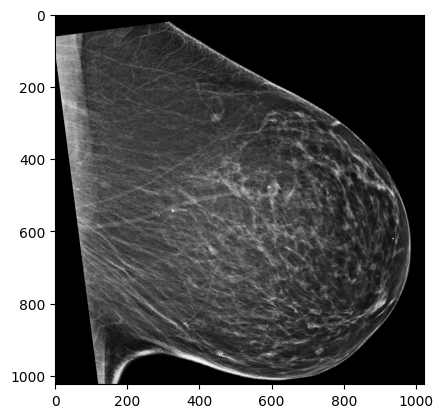

In [28]:
image=(train_ds[4].__getitem__(0))
#img =(image.transpose(1,2,0)* 255).numpy().astype(np.uint8)
#test=Image.fromarray(img)

#test
v = image.permute(1, 2, 0)
v -= v.min()
v /= v.max()
plt.imshow(v)
#img=(image.numpy().transpose(1,2,0)).astype(np.uint8)
#test=Image.fromarray(img)
#test

In [29]:
image.shape

torch.Size([3, 1024, 1024])

In [30]:
X_val['cancer'].value_counts()


0    5355
1     116
Name: cancer, dtype: int64

In [31]:
X_train['view'].value_counts()

5    25088
1    24113
0       18
2        9
4        7
Name: view, dtype: int64

In [32]:
def data_to_device(data):
    
    image, metadata, targets = data
    return image.to('cuda'), metadata.to('cuda'), targets.to('cuda')

In [33]:
y_train=X_train['cancer'].values
y_val=X_val['cancer'].values
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
class_sample_count[1]=class_sample_count[1]*4

#class_weights_train=compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
#class_weights_train=torch.tensor(class_weights_train,dtype=torch.float)
#class_weights_val=compute_class_weight(class_weight='balanced',classes=np.unique(y_val),y=y_val)
#class_weights_val=torch.tensor(class_weights_val,dtype=torch.float)

In [34]:
class_sample_count[1]=class_sample_count[1]*4
class_sample_count

array([48193, 16672])

In [35]:
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
class_sample_count[1]=class_sample_count[1]*4

weight = 1. / class_sample_count
samples_weight_train = np.array([weight[t] for t in y_train])
samples_weight_train = torch.from_numpy(samples_weight_train)


samples_weight_train

tensor([2.0750e-05, 2.0750e-05, 2.0750e-05,  ..., 2.0750e-05, 2.0750e-05,
        2.0750e-05], dtype=torch.float64)

In [36]:
class_sample_count= [len(np.where(y_val == t)[0]) for t in np.unique(y_val)]
class_sample_count[1]=928*4
class_sample_count=np.array(class_sample_count)
weight = 1. / class_sample_count

samples_weight_val = np.array([weight[t] for t in y_val])
samples_weight_val = torch.from_numpy(samples_weight_val)
samples_weight_val

tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
       dtype=torch.float64)

In [37]:
class_sample_count
weight

array([0.00018674, 0.0002694 ])

In [38]:
def computed_weight2(y,multi):
    class_sample_count= [len(np.where(y == t)[0]) for t in np.unique(y)]
    class_sample_count[1]= int((class_sample_count[1]+class_sample_count[0])*multi)
    class_sample_count=np.array(class_sample_count)
    weight = 1. / class_sample_count
    samples_weight_val = np.array([weight[t] for t in y])
    samples_weight_val = torch.from_numpy(samples_weight_val)
    return samples_weight_val


In [39]:
weight_train=computed_weight2(X_train['cancer'].values,0.15)


In [40]:
def computed_weight(y,multi):
    class_sample_count= [len(np.where(y == t)[0]) for t in np.unique(y)]
    class_sample_count[1]= class_sample_count[1]*multi
    class_sample_count=np.array(class_sample_count)
    weight = 1. / class_sample_count
    samples_weight_val = np.array([weight[t] for t in y])
    samples_weight_val = torch.from_numpy(samples_weight_val)
    return samples_weight_val


In [41]:
#y_train = [dataset.targets[i] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

In [42]:
from torch.utils.data import WeightedRandomSampler
weights_p=WEIGHTS_P
weight_train=computed_weight2(X_train['cancer'].values,weights_p)
weight_val=computed_weight(X_val['cancer'].values,2)
sampler_train =WeightedRandomSampler(weight_train.type('torch.DoubleTensor'), len(weight_train))
#WeightedRandomSampler(samples_weight_train.type('torch.DoubleTensor'), len(samples_weight_train))
sampler_val = WeightedRandomSampler(weight_val.type('torch.DoubleTensor'), len(weight_val))
#WeightedRandomSampler(samples_weight_val.type('torch.DoubleTensor'), len(samples_weight_val))
train_loader=torch.utils.data.DataLoader(dataset=train_ds,batch_size=BATCH_SIZE,num_workers=4,sampler=sampler_train)
val_loader=torch.utils.data.DataLoader(dataset=val_ds,batch_size=BATCH_SIZE,num_workers=4)
test_loader=torch.utils.data.DataLoader(dataset=test_ds,batch_size=BATCH_SIZE,num_workers=4)
print(len(train_ds), len(train_loader))

#plt.imshow((train_ds.__getitem__(8)[0]).permute(1, 2, 0))
#plt.imshow(train_ds.__getitem__(2)[0].permute(1, 2, 0))

#image, meta = train_ds.__getitem__(1)
#plt.imshow(train_ds.__getitem__(8)[0])
#image.shape

#print(meta)
#print(image.shape)

#print(targets)

49235 6155


In [43]:
#timm.list_models(pretrained=True)

In [44]:
import timm 
test=timm.create_model('efficientnet_b0',pretrained=True,num_classes=1,drop_rate=0.99)
seresnext50 = timm.create_model('seresnext50_32x4d',pretrained=True,drop_rate=0.9,num_classes=1)
#timm.list_models(pretrained=True)
#print(seresnext50)


In [45]:
test.train()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [46]:
test.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'architecture': 'efficientnet_b0'}

In [47]:
for name,param in seresnext50.named_parameters():
    param.requires_grad=False
layer_to_learn=[seresnext50.layer4,seresnext50.fc,seresnext50.global_pool]#res18.layer4
for layer in layer_to_learn:
    for param in layer.parameters():
        param.requires_grad=True

In [48]:

import torchvision.models as models

torch.cuda.is_available()
res18 = models.resnet50(pretrained=False)
for name,param in res18.named_parameters():
    param.requires_grad=False
    
#res18.fc=nn.Linear(256, 1)
#res18.load_state_dict(torch.load('/home/sef/Untitled Folder 1/L_R_MODEL_IMG_SIZE512_Epoch10_F1_0.755_Weight0.090.pth'),strict=False) 
#res18.fc=nn.Linear(2048, 1024)
#res18.fc=nn.Linear(512, 512)
#res18.conv1=nn.Conv2d(1, 64, kernel_size=7,padding=3, stride=2 )
#res18.fc=nn.Linear(512, 512)

res18.fc=nn.Linear(2048, 1)
res18=res18.to("cuda")

params_to_update = res18.parameters()

     


/home/sef/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sef/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [49]:
print(res18)
layer_to_learn=[res18.layer4,res18.avgpool]#res18.layer4
for layer in layer_to_learn:
    for param in layer.parameters():
        param.requires_grad=True
params_to_update = res18.parameters()
print("Params")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
eff0 = models.efficientnet_b4(pretrained=True)


/home/sef/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
eff0 = models.efficientnet_b4(weights='EfficientNet_B4_Weights.DEFAULT')
for name,param in eff0.named_parameters():
    param.requires_grad=False
#print(eff0)
eff0.features[4][2]
layer_to_learn=[eff0.features[3][2],eff0.features[4],eff0.features[5],eff0.features[6],eff0.features[7],eff0.features[8],eff0.classifier,eff0.avgpool]
for layer in layer_to_learn:
    for param in layer.parameters():
        param.requires_grad=True
eff0.classifier[0]=nn.Dropout(p=0.8)
eff0.classifier[1]=nn.Linear(1792, 1)
params_to_update=eff0.parameters()

In [52]:
print(eff0)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [53]:
#eff0.classifier[1]=nn.Linear(1280, 1000)

In [54]:
#eff0=eff0.to("cuda")

#params_to_update = eff0.parameters()

In [55]:
class ResNet50Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define Feature part (IMAGE)
        self.features = eff0
                                      # 1000 neurons out
        # (metadata)
        self.csv = nn.Sequential(nn.Linear(2, 100),
                                 nn.BatchNorm1d(100),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3))
        
        # Define Classification part
        self.classification = nn.Linear(1000+ 100, 1)
        
        
    def forward(self, image, meta):
      
        # Image CNN
        image = self.features(image)
        
        
        # CSV FNN
        meta = self.csv(meta)
       
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        
        return out

In [56]:
model_example = eff0.to('cuda')

print(len(train_ds))
y=X_train['cancer'].values
#class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
#class_weights=torch.tensor(class_weights,dtype=torch.float)
#class_weights.to('cuda')
print(seresnext50.parameters())

optimizer=optim.Adam(model_example.parameters(), lr=0.001) 
#cancer_loss = nn.functional.binary_cross_entropy_with_logits(pos_weight=torch.tensor([23]).to('cuda'))

#params_to_update,
#weight=class_weights
#loss_fn=nn.CrossEntropyLoss(pos_w``eight=torch.tensor([23]).to('cuda'))
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn=nn.BCELoss()
loss_fn.to('cuda')
#class_weights

49235
<generator object Module.parameters at 0x7fc4f5437ed0>


BCEWithLogitsLoss()

In [57]:
from torchmetrics.classification import F1Score
f1 = F1Score(task="binary", num_classes=2)


In [58]:
#for name,param in model_example.named_parameters():
 #   if param.requires_grad == True:
 #       print("\t",name)


In [59]:
#model_example.load_state_dict(torch.load('/home/sef/Untitled Folder 1/IMG_SIZE1024_Epoch15_F1_0.124_Weight0.100.pth'))

In [60]:

#checkpoint = torch.load('/home/sef/Untitled Folder 1/checkpoint5.pth')
#model_example.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [61]:
#torch.save(model_example, 'full_model.pt')

In [62]:


def probabilistic_f1(labels, predictions, beta=0.5):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
            cfp += 1 - prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0
def pfbeta_torch(labels, preds, beta=1):
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0

In [63]:
scaler = torch.cuda.amp.GradScaler()

In [64]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [65]:
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=5, verbose=True, factor=0.9)

In [66]:
from sklearn.metrics import roc_auc_score

In [67]:

f_outputs=[]

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=40, device="cuda"):
    best_f1=0.25
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            #inputs,meta,targets = batch
            #meta=meta.to(device)
            inputs,meta,targets = batch
            inputs = inputs.to(device)
            #meta=meta.to(device)
            targets = targets.to(device)
            #loss = loss_fn(output, targets)
            with torch.cuda.amp.autocast():
                output = model(inputs)
                loss = loss_fn(output, targets.unsqueeze(1).float())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            training_loss += loss.item()* inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        f_outputs=[]
        f_targets=[]
        test=[]
        roc_out=[]
        num_correct = 0 
        num_examples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs,meta,targets = batch
                inputs = inputs.to(device)
                #meta=meta.to(device)
                targets = targets.to(device)
                #preds = model(inputs).squeeze()
                with torch.cuda.amp.autocast():
                    output = model(inputs)
                    loss = loss_fn(output, targets.unsqueeze(1).float())
        
                
                #loss = loss_fn(output,targets) 
                
                valid_loss += loss.data.item()* inputs.size(0)
                #pred=torch.argmax(output,dim=1)
                prob_preds=torch.sigmoid(output)
                train_preds = torch.round(torch.sigmoid(output))
                test.append(torch.max(torch.sigmoid(output)))
                f_outputs.extend(train_preds.cpu().numpy().tolist())
                roc_out.extend(prob_preds.cpu().numpy().tolist())
                f_targets.extend(targets.unsqueeze(1).cpu().float().tolist())#.tolist())
                correct = torch.eq(torch.round(torch.sigmoid(output)), targets.unsqueeze(1))
                #correct = (train_preds.cpu() == targets.unsqueeze(1)).sum().item()
                #correct = torch.eq(torch.argmax(output,dim=1), targets)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        #MultiLabelBinarizer().fit_transform(f_outputs)
        #MultiLabelBinarizer().fit_transform(f_targets)
        prob_predicts=np.concatenate(roc_out)
        predictions = np.concatenate(f_outputs)
        np_f_targets=np.concatenate(f_targets)
        prob_f1_score=probabilistic_f1(np_f_targets,prob_predicts)
        roc=roc_auc_score(np_f_targets,prob_predicts)
        sk_fbeta_score=probabilistic_f1(np_f_targets,prob_predicts,beta=1)
        recall=recall_score(f_targets,f_outputs,zero_division=0)
        precision=precision_score(f_targets,f_outputs,zero_division=0)
        scheduler.step(sk_fbeta_score)
 
        

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
            valid_loss, num_correct / num_examples))
        #print('fbeta_score: {}'.format(sk_fbeta_score))
        print('f1_score_beta: {}'.format(prob_f1_score))
        print('f1_score: {}'.format(sk_fbeta_score))
        print('recall_score: {}'.format(recall))
        print('precision_score: {}'.format(precision))
        print('roc_auc_score: {}'.format(roc))
        
        #print(f_outputs) 
        ##print(f_targets)
        #print(predictions)
        #print(np_f_targets)
        model_name = f"IMG_SIZE{SIZE}_Epoch{epoch}_F1_{sk_fbeta_score:.3f}_Weight{weights_p:.3f}.pth"
        if  epoch in [10,15,20,25,30]:
            torch.save(model.state_dict(), model_name)
        if  sk_fbeta_score-best_f1>0.002:
            best_f1=sk_fbeta_score
            torch.save(model.state_dict(), model_name)    
            
    del inputs, targets, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

     


In [68]:


train(model_example, optimizer,loss_fn, train_loader,val_loader)


#from sklearn.metrics import roc_auc_score
     


KeyboardInterrupt: 

In [ ]:
torch.save({
            'epoch': 9,
            'model_state_dict': model_example.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           
            }, 'checkpoint9.pth')
#train(model_example, optimizer,loss_fn, train_loader,val_loader, epochs=40)

In [ ]:
roc_auc_score: 0.7546431791107246

In [ ]:
best_roc=None
def fold_train(model,df,epochs=3,device='cuda'):
    group_fold = GroupKFold(n_splits = 3)
    k_folds = group_fold.split(X = np.zeros(len(df)), 
                               y = df['cancer'], 
                               groups = df['patient_id'].tolist())

    best_roc=None
    for i, (train_index, valid_index) in enumerate(k_folds):
        print(f"---------- Fold: {i+1} ----------")
        train_data = df.iloc[train_index].reset_index(drop=True)
        valid_data = df.iloc[valid_index].reset_index(drop=True)
        weights_train=computed_weight(train_data['cancer'].values,3)
        weights_val=computed_weight(valid_data['cancer'].values,3)
        train_ds=dataset(df=train_data,transform=transform_train)
        val_ds=dataset(df=valid_data,transform=transform_val)
        weights_train=computed_weight2(train_data['cancer'].values,WEIGHTS_P)
        weights_val=computed_weight(valid_data['cancer'].values,3)
        sampler_train = WeightedRandomSampler(weights_train.type('torch.DoubleTensor'), len(weights_train))
        sampler_val = WeightedRandomSampler(weights_val.type('torch.DoubleTensor'), len(weights_val))
        train_loader=torch.utils.data.DataLoader(dataset=train_ds,batch_size=32,num_workers=4,sampler=sampler_train)
        val_loader=torch.utils.data.DataLoader(dataset=val_ds,batch_size=32,num_workers=4)
        for epoch in range(1, epochs+1):
            training_loss = 0.0
            valid_loss = 0.0
            model.train()
            for batch in train_loader:
                optimizer.zero_grad()
            #inputs,meta,targets = batch
            #meta=meta.to(device)
                inputs,meta,targets = batch
                inputs = inputs.to(device)
                meta=meta.to(device)
                targets = targets.to(device)
            #loss = loss_fn(output, targets)
                with torch.cuda.amp.autocast():
                    output = model(inputs,meta)
                    loss = loss_fn(output, targets.unsqueeze(1).float())
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                training_loss += loss.item()* inputs.size(0)
            training_loss /= len(train_loader.dataset)
        
            model.eval()
            f_outputs=[]
            f_targets=[]
            test=[]
            num_correct = 0 
            num_examples = 0
            with torch.no_grad():
                for batch in val_loader:
                    inputs,meta,targets = batch
                    inputs = inputs.to(device)
                    meta=meta.to(device)
                   
                    #preds = model(inputs).squeeze()
                    
                    targets = targets.to(device)

                    #loss = loss_fn(output,targets) 
                    
                    with torch.cuda.amp.autocast():
                        output = model(inputs,meta)
                        loss = loss_fn(output, targets.unsqueeze(1).float())
                    valid_loss += loss.data.item()* inputs.size(0)
                    pred=torch.argmax(output,dim=1)
                    train_preds = torch.round(torch.sigmoid(output))
                    test.append(torch.max(torch.sigmoid(output)))
                    f_outputs.extend(train_preds.cpu().numpy().tolist())
                    f_targets.extend(targets.unsqueeze(1).cpu().float().tolist())#.tolist())
                    correct = torch.eq(torch.round(torch.sigmoid(output)), targets.unsqueeze(1))
                    #correct = (train_preds.cpu() == targets.unsqueeze(1)).sum().item()
                    #correct = torch.eq(torch.argmax(output,dim=1), targets)
                    num_correct += torch.sum(correct).item()
                    num_examples += correct.shape[0]
            valid_loss /= len(val_loader.dataset)
            #MultiLabelBinarizer().fit_transform(f_outputs)
            #MultiLabelBinarizer().fit_transform(f_targets)
            predictions = np.concatenate(f_outputs)
            np_f_targets=np.concatenate(f_targets)
            prob_f1_score=probabilistic_f1(np_f_targets,predictions)
            sk_fbeta_score=probabilistic_f1(np_f_targets,predictions,beta=1)
            recall=recall_score(f_targets,f_outputs,zero_division=0)
            precision=precision_score(f_targets,f_outputs,zero_division=0)
            valid_roc = roc_auc_score(f_targets,f_outputs)
            model_name = f"Fold{i+1}_Epoch{epoch+1}_ValidAcc{num_correct / num_examples:.3f}_ROC{valid_roc:.3f}.pth"
            if not best_roc: # If best_roc = None
                best_roc = valid_roc
                torch.save(model.state_dict(), model_name)
                
            if valid_roc > best_roc:
                best_roc = valid_roc
                torch.save(model.state_dict(), model_name)


            print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
                valid_loss, num_correct / num_examples))
            #print('fbeta_score: {}'.format(sk_fbeta_score))
            print('f1_score_beta: {}'.format(prob_f1_score))
            print('f1_score: {}'.format(sk_fbeta_score))
            #print('recall_score: {}'.format(recall))
            #print('precision_score: {}'.format(precision))
            #print('valid_roc: {}'.format(valid_roc))
        
    
    del inputs, targets, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    

In [ ]:

#model_example.load_state_dict(torch.load('/home/sef/Untitled Folder 1/IMG_SIZE512_Epoch9_F1_0.154_Weight0.100.pth')) 
#fold_train(model_example,X)

In [ ]:
def test(val_loader,threshold,device='cuda',loss_fn=loss_fn,printed=True):
    model = model_example
    path = "/media/sef/Data/rsna-breast-cancer-detection/Load/IMG_SIZE512_Epoch8_F1_0.196_Weight0.100.pth" 
    model.load_state_dict(torch.load(path)) 
    valid_loss = 0.0
    running_accuracy = 0 
    total = 0 
    model.eval()
    f_outputs=[]
    f_targets=[]
    test=[]
    num_correct = 0 
    num_examples = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs,meta,targets = batch
            inputs = inputs.to(device)
           # meta=meta.to(device)
            
            #preds = model(inputs).squeeze()
            
            targets = targets.to(device)

            with torch.cuda.amp.autocast():
                output = model(inputs)
                loss = loss_fn(output, targets.unsqueeze(1).float())      #loss = loss_fn(output,targets) 
                    
           
            valid_loss += loss.data.item()* inputs.size(0)
            pred=torch.argmax(output,dim=1)
            train_preds = torch.where(torch.sigmoid(output)>threshold,1.0,0.0)
            test.append(torch.max(torch.sigmoid(output)))
            f_outputs.extend(train_preds.cpu().numpy().tolist())
            f_targets.extend(targets.unsqueeze(1).cpu().float().tolist())#.tolist())
            correct = torch.eq(torch.round(torch.sigmoid(output)), targets.unsqueeze(1))
                    #correct = (train_preds.cpu() == targets.unsqueeze(1)).sum().item()
                    #correct = torch.eq(torch.argmax(output,dim=1), targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
    valid_loss /= len(val_loader.dataset)
    #MultiLabelBinarizer().fit_transform(f_outputs)
        #MultiLabelBinarizer().fit_transform(f_targets)
    predictions = np.concatenate(f_outputs)
    np_f_targets=np.concatenate(f_targets)
    prob_f1_score=probabilistic_f1(np_f_targets,predictions)
    sk_fbeta_score=probabilistic_f1(np_f_targets,predictions,beta=1)
    recall=recall_score(f_targets,f_outputs,zero_division=0)
    precision=precision_score(f_targets,f_outputs,zero_division=0)
    if printed:
        print('Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
                    valid_loss, num_correct / num_examples))
            #print('fbeta_score: {}'.format(sk_fbeta_score))
        print('f1_score_beta: {}'.format(prob_f1_score))
        print('f1_score: {}'.format(sk_fbeta_score))
        print('recall_score: {}'.format(recall))
        print('precision_score: {}'.format(precision))
    else:return sk_fbeta_score
    del inputs, targets, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    
    

In [ ]:
maxf1=0
thres_res=0
for thres in np.arange(0.0,1.1,0.1):
    test_f1=test(test_loader,thres,printed=False)
    if test_f1>maxf1:
        thres_res=thres
        maxf1=test_f1
maxf1

In [ ]:
thres_res

In [ ]:
test(test_loader,0.4)

In [ ]:
test(test_loader,0.2)

In [ ]:
test(val_loader,0.6)

In [ ]:
all_pred=[]
def pred(val_loader,device='cuda'):
    model = model_example
    path = "/home/sef/Untitled Folder 1/Fold3_Epoch2_ValidAcc0.900_ROC0.857.pth" 
    model.load_state_dict(torch.load(path)) 
    valid_loss = 0.0
    running_accuracy = 0 
    total = 0 
    model.eval()
    f_outputs=[]
    f_targets=[]
    test=[]
    num_correct = 0 
    num_examples = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs,meta= batch
            inputs = inputs.to(device)
            meta=meta.to(device)
            output = model(inputs,meta)
            #preds = model(inputs).squeeze()

            pred=torch.argmax(output,dim=1)
            train_preds = torch.sigmoid(output)
            test.append(torch.round(torch.sigmoid(output)))
            f_outputs.extend(train_preds.cpu().numpy().tolist())
    predictions = np.concatenate(f_outputs)
    all_pred.extend(predictions)
   
  


    

In [ ]:
df=X_val.copy()

In [ ]:
all_pred=[]
#pred(val_loader)
#preds = preds
#df["cancer"] = all_pred

In [ ]:
#df.info()

In [ ]:
#df['cancer'].value_counts()
#df['laterality']='L'

In [ ]:

#df['prediction_id'] = df['patient_id'].astype(str) + "_" + df['laterality']

#sub = df[['prediction_id', 'cancer']].groupby("prediction_id").mean().reset_index()

In [ ]:
#sub

In [ ]:
vgg11 = models.vgg11(pretrained=True)
for name,param in vgg11.named_parameters():
    param.requires_grad=False

vgg11.features[0]=nn.Conv2d(1, 64, kernel_size=3,padding=1, stride=1 )
vgg11.classifier[6]=nn.Linear(4096, 2)
layer_to_learn=[]
for layer in layer_to_learn:
    for param in layer.parameters():
        param.requires_grad=True

print("Params")
params_to_update = []
for name,param in vgg11.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
vgg11.to('cuda')

In [ ]:
#optimizer=optim.Adam(params_to_update, lr=0.001)

In [ ]:
#res50.train()

In [ ]:
#train(vgg11, optimizer,loss_fn, train_loader,val_loader)

In [ ]:
all_images = glob.glob(os.path.join(train_data_png_path,'*.png')) 


In [ ]:
train_data_png_path


In [ ]:


from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import re
import pydicom
from tqdm import tqdm

def fit_image(fname, size=512):
    # 1. Read, resize
    
    
    patient = fname.split('/')[-1].split('_')[0]
    image = fname.split('/')[-1].split('_')[1]
    
    #dicom = pydicom.dcmread(fname)
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    if (img.max()- img.min())!=0:
        img = (img - img.min()) / (img.max() - img.min())
    #img=test_pad(img)
    #if dicom.PhotometricInterpretation == "MONOCHROME1":
     #   img = 1 - img
    
    
    # 2. Crop
    X = img
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
    X = X[5:-5, 5:-5]
    
    
    # regions of non-empty pixels
    output= cv2.connectedComponentsWithStats((X > 0.05).astype(np.uint8)[:, :], 8, cv2.CV_32S)

    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]
    
    # finding max area which always corresponds to the breast data. 
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    # cutting out the breast data
    X_fit = X[y1: y2, x1: x2]
    X_fit=np.array(test_pad(X_fit))
    X_fit = cv2.resize(X_fit, (size, size))
    cv2.imwrite('/media/sef/Data/rsna-breast-cancer-detection/roi_pad_512/' + f"{patient}_{image}", (X_fit[:, :] * 255).astype(np.uint8))

def fit_all_images(all_images):
    with ThreadPoolExecutor(2) as p:
        for i in tqdm(p.map(fit_image, all_images), total=len(all_images)):
            pass

all_images = glob.glob(os.path.join(train_data_png_path,'*.png')) 
# all_images = glob.glob('/kaggle/input/rsna-breast-cancer-detection/train_images/10006/*')
fit_all_images(all_images)



In [ ]:
fname='/media/sef/Data/rsna-breast-cancer-detection/train_png_1024/5_640805896.png'

In [ ]:
def test_pad(image):
    image=Image.fromarray(image)
    max_wh = max(image.size)
    max_wh=max(max_wh,512)
    p_left, p_top = [(max_wh - s) // 2 for s in image.size]
    p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
    padding = (p_left, p_top, p_right, p_bottom)
    return F.pad(image, padding, 0, 'constant')

In [ ]:
img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
img.shape
if (img.max()- img.min())!=0:
        img = (img - img.min()) / (img.max() - img.min())
#img.shape
X = img
X = X[5:-5, 5:-5]
patient=1
image=2
    
    # regions of non-empty pixels
output= cv2.connectedComponentsWithStats((X > 0.05).astype(np.uint8)[:, :], 8, cv2.CV_32S)

    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
stats = output[2]
    
    # finding max area which always corresponds to the breast data. 
idx = stats[1:, 4].argmax() + 1
x1, y1, w, h = stats[idx][:4]
x2 = x1 + w
y2 = y1 + h
    
    # cutting out the breast data
X_fit = X[y1: y2, x1: x2]

#max((X_fit[:, :] * 255).astype(np.uint8).shape)
X_fit=np.array(test_pad(X_fit))
cv2.imwrite('/media/sef/Data/rsna-breast-cancer-detection/' + f"{patient}_{image}", (X_fit[:, :] * 255).astype(np.uint8))


In [ ]:
model = torch.hub.load('./yolov5', 'custom', path='/home/sef/Untitled Folder 1/model/rsna-roi-003.pt', source='local')


In [ ]:

model.to('cuda') ## model to GPU


In [ ]:
from tqdm import tqdm
file_list=train_data_png
images = []
error_counter = 0
for img_file in tqdm(file_list):
    #print(img_file)
    # Read file from file
    frame = cv2.imread(img_file)
    
    # Make prediction
    detections = model(frame)
    
    # Convert results to Pandas style
    results = detections.pandas().xyxy[0].to_dict(orient="records")    
    
    # Plot result (in 99.99% it predicts only one instance - certainly you can assure that only best prediction 
    #is used)
    for result in results:
        images.append(cv2.rectangle(frame, (int(result['xmin']), int(result['ymin'])), (int(result['xmax']), int(result['ymax'])), (255,0,0), 4))

    ##########
    # new... create croopped images from test folder save to new folder
    ##########
    if results and isinstance(results[0], dict) and len(results[0]) >= 4:
        b_box_values = [v for i, (k, v) in enumerate(results[0].items()) if i < 4]    
    else:
        # handle the case where the results list is empty or the first element is not a dictionary with at least 4 items
        error_counter +=1
        height, width, channels = frame.shape
        b_box_values = [0, 0, height, width]         
    

    temp_file = cv2.imread(img_file)
    x1, y1, x2, y2 = map(int, b_box_values)
    cropped_file = temp_file[y1:y2, x1:x2]
    cv2.imwrite(f'/media/sef/Data/rsna-breast-cancer-detection/roi_512_model/{os.path.basename(img_file)}', cropped_file)

print(f'Files errorered in bbox extraction: {error_counter} total files: {len(file_list)}')

In [ ]:
train_data_png_path